# Stock prediction
We use the previous data to predict that whether the next minute's stock price will increase 
or decrease. In this way, we can make high frequency trading.
In this project, we mainly focus on building models to train the data form Apple's Stock. At the beggining we try to use feedforward neural network 

Designed by: Xiang Li(N17166054) & Ruicheng Fan(N11416899)

## Loading packets


In [26]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import pydot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import RNN
from keras.layers import LSTM, Dropout
from keras import optimizers
import keras.regularizers as regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import datasets, linear_model, preprocessing
import seaborn as sns
import sklearn
%matplotlib inline

In [27]:
NumHiddenLayers = 6
_batch_size = 20
ws=4               #window size
seed = 7
np.random.seed(seed)

## Load data
Here we set a fuature mask which indicate which feature will be used in trainning.We get data from https://www.finam.ru/profile/akcii-usa-bats/3m-co/export/?market=25&em=18090&code=MMM&apply=0&df=19&mf=10&yf=2017&from=19.11.2017&dt=19&mt=10&yt=2017&to=19.11.2017&p=7&f=MMM_171119_171119&e=.txt&cn=MMM&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=1&sep2=1&datf=1&at=1#, we get every minute's data of Apple's Stock. This data contains TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL features, then we transform these datas to CLOSE,HIGH,LAST,LOW,OPEN,PEAK1,PEAK1_FREQ,STD,VOL,Z1,Z2,RETURN,RETURN_CLOSING,HOUR,MIN,RESUL. We make a foruier transorm of last price, the we can get some peak and the frequency the peak appears, we record them as  'PEAK1' and 'PEAK1_FREQ'。 'STD' is the standard deviation of last price. 'Z1' is the parameter of linear regression, 'Z2' is the parameter of polynomial linear regression. RETURN is a important parameter which is ofent used in market prediction, it defined as ((last price - price now)/price now) . RESULT indicate whether the price increase or decrease,RESULT=1 means increase.

In [44]:
features_mask = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],dtype = bool) # change the first 8 to turn on and off 
minute_data_ = pd.read_csv('minute_data_restart.txt')
minute_data_ = minute_data_.loc[:,features_mask]
minute_data_ = minute_data_.loc[:,['CLOSE','HIGH','LAST','LOW','OPEN','PEAK1','PEAK1_FREQ','STD','VOL','Z1','Z2','RETURN','RETURN_CLOSING','HOUR','MIN','RESULT']]
minute_data_

,CLOSE,HIGH,LAST,LOW,OPEN,PEAK1,PEAK1_FREQ,STD,VOL,Z1,Z2,RETURN,RETURN_CLOSING,HOUR,MIN,RETURN_DAILY,RESULT
0,111.250000,111.430000,111.327949,111.212857,111.420000,0.568381,1.0,0.062441,99.732501,-0.003438,-9.458951e-06,0.000000,0.000000,9.0,30.0,-0.001527,0
1,111.300000,111.300000,111.204499,111.150000,111.250000,0.585147,1.0,0.040665,88.210662,0.000563,1.275366e-04,0.000000,0.000000,9.0,31.0,0.000449,1
2,111.295000,111.338571,111.296852,111.270000,111.306667,0.370719,2.0,0.012354,72.706349,-0.000484,8.890208e-06,-0.001109,0.000449,9.0,32.0,-0.000105,0
3,111.170000,111.290000,111.167041,111.130000,111.290000,0.426570,1.0,0.040090,69.396519,-0.001152,1.008551e-04,0.000830,-0.000045,9.0,33.0,-0.001079,0
4,111.055000,111.230000,111.166040,111.055000,111.200000,0.487300,1.0,0.050295,56.049582,-0.002840,-6.374646e-05,-0.001167,-0.001124,9.0,34.0,-0.001305,0
5,111.220000,111.250000,111.124416,111.050000,111.050000,0.511936,1.0,0.053816,48.888085,0.002737,2.956241e-05,-0.000009,-0.001035,9.0,35.0,0.001530,1
6,111.223333,111.328889,111.284495,111.220000,111.232500,0.584044,1.0,0.028583,96.259939,-0.001038,-6.043944e-05,-0.000374,0.001485,9.0,36.0,-0.000082,0
7,110.943333,111.220000,111.088042,110.938000,111.220000,0.320887,3.0,0.052056,81.536111,-0.002343,2.924450e-05,0.001440,0.000030,9.0,37.0,-0.002491,0
8,110.890000,110.980000,110.921965,110.860000,110.960000,0.653452,1.0,0.040798,90.794745,-0.001941,2.762693e-05,-0.001767,-0.002521,9.0,38.0,-0.000631,0
9,110.800000,110.908333,110.850611,110.760000,110.880000,0.538666,1.0,0.034953,87.748297,-0.001859,-2.094817e-05,-0.001496,-0.000481,9.0,39.0,-0.000722,0


Set the size of train data and test data 

In [45]:
trainSize = int(len(minute_data_)*0.67)
dataframe = minute_data_.loc[0:trainSize].copy()
dataframetest = minute_data_.loc[trainSize::].copy()
dataset = dataframe.values
n_inputs = len(minute_data_.columns)-1

In [46]:
dataset_test = dataframetest.values
# split into input (X) and output (Y) variables
X = dataset[:,0:n_inputs].astype(float)
Y = dataset[:,n_inputs]
Xtest = dataset_test[:,0:n_inputs].astype(float)
Ytest = dataset_test[:,n_inputs]

Define get_stacke_num() function to stack the data, for example, num=15, we get 15 minutes data as input, since every minute's data has relation with next minute, also we need next minute's price to know 'RESULT', so we get evrery 15 minutes data, and compare with every next minutes to get some features.

In [47]:
def get_stacked_15(X,Y):   
    X_n = np.hstack((X[0:-14],X[1:-13]))
    X_n = np.hstack((X_n,X[2:-12]))
    X_n = np.hstack((X_n,X[3:-11]))
    X_n = np.hstack((X_n,X[4:-10]))
    X_n = np.hstack((X_n,X[5:-9]))
    X_n = np.hstack((X_n,X[6:-8]))
    X_n = np.hstack((X_n,X[7:-7]))
    X_n = np.hstack((X_n,X[8:-6]))
    X_n = np.hstack((X_n,X[9:-5]))
    X_n = np.hstack((X_n,X[10:-4]))
    X_n = np.hstack((X_n,X[11:-3]))
    X_n = np.hstack((X_n,X[12:-2]))
    X_n = np.hstack((X_n,X[13:-1]))
    X_n = np.hstack((X_n,X[14::]))
    Y_n = Y[14::]
    return X_n,Y_n
def get_stacked_10(X,Y):   
    X_n = np.hstack((X[0:-9],X[1:-8]))
    X_n = np.hstack((X_n,X[2:-7]))
    X_n = np.hstack((X_n,X[3:-6]))
    X_n = np.hstack((X_n,X[4:-5]))
    X_n = np.hstack((X_n,X[5:-4]))
    X_n = np.hstack((X_n,X[6:-3]))
    X_n = np.hstack((X_n,X[7:-2]))
    X_n = np.hstack((X_n,X[8:-1]))
    X_n = np.hstack((X_n,X[9::]))
    Y_n = Y[9::]
    return X_n,Y_n

def get_stacked_5(X,Y):   
    X_n = np.hstack((X[0:-4],X[1:-3]))
    X_n = np.hstack((X_n,X[2:-2]))
    X_n = np.hstack((X_n,X[3:-1]))
    X_n = np.hstack((X_n,X[4::]))
    Y_n = Y[4::]
    return X_n,Y_n

def get_stacked_4(X,Y):   
    X_n = np.hstack((X[0:-3],X[1:-2]))
    X_n = np.hstack((X_n,X[2:-1]))
    X_n = np.hstack((X_n,X[3::]))
    Y_n = Y[3::]
    return X_n,Y_n
def get_stacked_3(X,Y):   
    X_n = np.hstack((X[0:-2],X[1:-1]))
    X_n = np.hstack((X_n,X[2::]))
    Y_n = Y[2::]
    return X_n,Y_n
def get_stacked_2(X,Y):   
    X_n = np.hstack((X[0:-1],X[1::]))
    Y_n = Y[1::]
    return X_n,Y_n
Stack_fun = [get_stacked_2,get_stacked_3,get_stacked_4,get_stacked_5,get_stacked_10]

In [48]:
X = np.nan_to_num(X)
Xtest = np.nan_to_num(Xtest)
X_scaled = preprocessing.scale(X)
Xtest_scaled = preprocessing.scale(Xtest)
n_inputs = len(X[0])

Build neural network model, since the output result is binary, we set the loss function 'binary_crossentropy' and activation 'sigmoid'.

In [49]:
model = Sequential()
for i in np.arange(NumHiddenLayers):
    if(int(n_inputs/(2**i))>=2):
        model.add(Dense(int(n_inputs/(2**i)), input_dim=n_inputs, kernel_initializer='normal', activation='relu'))

In [50]:
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

Train the data , we set batch_size 15 in order to find the best parameters.

In [51]:
history = model.fit(X_scaled, Y, epochs=10, batch_size=15, verbose=1, validation_data=(Xtest_scaled,Ytest))

Train on 9407 samples, validate on 4634 samples
Epoch 1/10
9407/9407 [==============================] - 1s - loss: 0.6927 - acc: 0.5190 - val_loss: 0.6918 - val_acc: 0.5313
Epoch 2/10
9407/9407 [==============================] - 1s - loss: 0.6925 - acc: 0.5195 - val_loss: 0.6916 - val_acc: 0.5313
Epoch 3/10
9407/9407 [==============================] - 1s - loss: 0.6924 - acc: 0.5195 - val_loss: 0.6915 - val_acc: 0.5313
Epoch 4/10
9407/9407 [==============================] - 2s - loss: 0.6924 - acc: 0.5195 - val_loss: 0.6914 - val_acc: 0.5313
Epoch 5/10
9407/9407 [==============================] - 1s - loss: 0.6925 - acc: 0.5195 - val_loss: 0.6915 - val_acc: 0.5313
Epoch 6/10
9407/9407 [==============================] - 1s - loss: 0.6924 - acc: 0.5195 - val_loss: 0.6913 - val_acc: 0.5313
Epoch 7/10
9407/9407 [==============================] - 1s - loss: 0.6925 - acc: 0.5195 - val_loss: 0.6914 - val_acc: 0.5313
Epoch 8/10
9407/9407 [==============================] - 1s - loss: 0.6924 - a

From the accuracy above, we find that we have 70% probability to indicate the stock will increase or decreas next minute. It's not very high, but for high frequency trading, this result is pretty good. In order to improve the accuracy, we try to plot the correlation of features, we want to know which feature weigh most important in the model.

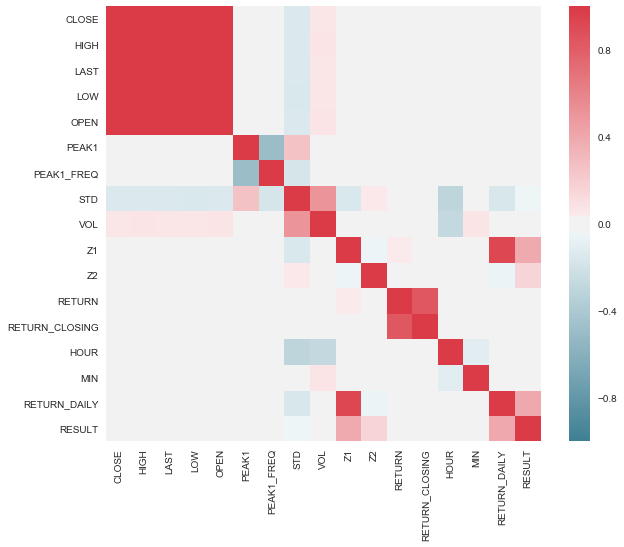

In [43]:
minute_data_ = pd.read_csv('minute_data_restart.txt')
minute_data_ = minute_data_.loc[:,['CLOSE','HIGH','LAST','LOW','OPEN','PEAK1','PEAK1_FREQ','STD','VOL','Z1','Z2','RETURN','RETURN_CLOSING','HOUR','MIN','RETURN_DAILY','RESULT']]
corr = minute_data_.corr()
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

We can find taht 'Z1','Z2' and 'RETURN_DAILY' has high correlation with result, so we try to use linear regression to train the data. The following step fix the data to linear regression.

In [37]:
minute_data_ = pd.read_csv('minute_data_restart.txt')
minute_data_ = minute_data_.loc[:,['PEAK1','PEAK1_FREQ','STD','VOL','RETURN','Z2',
'HOUR','MIN','RETURN_DAILY',]]

Here we use the return as input, we don't use price directly since every minute price has correlation with last minute, we set a new 'RESULT' data here, we use next minute's return as current result, from the defination of 'RETURN' above, we know that it indicat the amoout of increas or decrease compare to last minute price. So here we set a new  result, then we can know that the price is increase or decrease. 

In [38]:
newreturn = np.zeros(len(minute_data_))
newreturn[0:-1] = minute_data_.loc[1::,'RETURN']
minute_data_['RESULT'] = np.zeros(len(minute_data_))
minute_data_['RESULT'] = newreturn
minute_data_

,PEAK1,PEAK1_FREQ,STD,VOL,RETURN,Z2,HOUR,MIN,RETURN_DAILY,RESULT
0,0.568381,1.0,0.062441,99.732501,0.000000,-9.458951e-06,9.0,30.0,-0.001527,0.000000
1,0.585147,1.0,0.040665,88.210662,0.000000,1.275366e-04,9.0,31.0,0.000449,-0.001109
2,0.370719,2.0,0.012354,72.706349,-0.001109,8.890208e-06,9.0,32.0,-0.000105,0.000830
3,0.426570,1.0,0.040090,69.396519,0.000830,1.008551e-04,9.0,33.0,-0.001079,-0.001167
4,0.487300,1.0,0.050295,56.049582,-0.001167,-6.374646e-05,9.0,34.0,-0.001305,-0.000009
5,0.511936,1.0,0.053816,48.888085,-0.000009,2.956241e-05,9.0,35.0,0.001530,-0.000374
6,0.584044,1.0,0.028583,96.259939,-0.000374,-6.043944e-05,9.0,36.0,-0.000082,0.001440
7,0.320887,3.0,0.052056,81.536111,0.001440,2.924450e-05,9.0,37.0,-0.002491,-0.001767
8,0.653452,1.0,0.040798,90.794745,-0.001767,2.762693e-05,9.0,38.0,-0.000631,-0.001496
9,0.538666,1.0,0.034953,87.748297,-0.001496,-2.094817e-05,9.0,39.0,-0.000722,-0.000643


In [39]:
features_mask = np.ones(len(minute_data_.columns),dtype = bool)
feature_num = np.sum(features_mask)-1
trainSize = int(len(minute_data_)*0.80)
dataframe = minute_data_.loc[0:trainSize].copy()
dataframetest = minute_data_.loc[trainSize::].copy()
dataset = dataframe.values[:,features_mask].copy()
dataset_test = dataframetest.values[:,features_mask]

Scale the input and fix data as before, 'ws' is the window size which indicate how many minutes data we use as the input.

In [40]:
def scale(arr2d_):
    arr2d = arr2d_.copy()
    for i in range(len(arr2d[0])):
        slice1 = arr2d[:,i]
        avg = np.average(arr2d[:,i])
        std = np.std(arr2d[:,i])
        slice1 = (slice1 - avg) /(std)
        arr2d[:,i] =slice1
    return arr2d

def prepare_data(ws,feature_num,dataset,dataset_test):
    X = dataset[:,0:feature_num].astype(float)
    Y = dataset[:,feature_num]
    Xtest = dataset_test[:,0:feature_num].astype(float)
    Ytest = dataset_test[:,feature_num]
    #stack them.
    
    X,Y =Stack_fun[ws](X,Y)
    Xtest,Ytest = Stack_fun[ws](Xtest,Ytest)    
    X = np.nan_to_num(X)
    Xtest = np.nan_to_num(Xtest)
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled = scaler.fit_transform(values)
    X_scaled = scale(X)
    Xtest_scaled = scale(Xtest)
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    scaler.fit(Xtest)
    Xtest_scaled = scaler.transform(Xtest)
    n_inputs = len(X[0])
    return X_scaled, Xtest_scaled,Y, Ytest, n_inputs, Xtest
X_scaled, Xtest_scaled, Y, Ytest, n_inputs,Xtest= prepare_data(ws,feature_num,dataset,dataset_test)

Build a linear model and train it, we can use the model to predict every next minute return, for example, we get a return a1 at t minute, and a2 at t+1 minute, we use a2-a1 so that we can know form t minute previous data, at t+1 minute, the price whether increase or not. The directional accuracy indicate the probability that we predict the price whetehr increase or decrease.

In [41]:
regr = linear_model.LinearRegression()
regr.fit(X_scaled, Y)
#pred = regr.predict(X_scaled)
#mse = sklearn.metrics.mean_squared_error(pred,Y)
pred = regr.predict(Xtest_scaled)
mse = sklearn.metrics.mean_squared_error(pred,Ytest)
print('MSE for testing:'+str(mse))
mae = sklearn.metrics.mean_absolute_error(pred,Ytest)
print('MAE for testing:'+str(mae))
a = np.sign(pred[1::] - pred[0:-1])
b = np.sign(Ytest[1::] - Ytest[0:-1])
acc = np.sum(a == b)/float(len(a))
print('Directional Accuracy: '+str(acc))

MSE for testing:1.80457112744e-07
MAE for testing:0.000150797684964
Directional Accuracy: 0.828806290207


After using linear regression, the accuray increase about 12%.
Summary: For stock prediction, normally lstm neural network or feedforwd neural network should have better result. However, linear regression has a higher accuracy. This because we didn't find approaiate feature, we choose 'Z1' here which has great influence on the result, and 'Z1' is the parameter of  linear regression. Since the price of stock is too random, so it's hardly to find the relation. Compare to most stock prediction online, this stock prediction model predict next minute's trend of stock, not a next day or next month, it is much harder to predict next one minute sunce the trend of stock is too fluctuating. If we have a good strategy，and we put the tax of trading, 70% is sufficient for us  to make profit from stock prediction. Also, if we can find a better feature, the accuray can reach a high level.